In [1]:
# =============================================================================
# 1. CONFIGURACIÓN E IMPORTACIONES
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os, random
import joblib
from tqdm import tqdm
import shap

# Scikit-Learn
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost
import xgboost as xgb

# TensorFlow / Keras (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Modelos de Panel
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# Configuración Global
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

SEED = 505
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# =============================================================================
# 2. CARGA DE DATOS Y PREPARACIÓN
# =============================================================================
url = "https://raw.githubusercontent.com/rortizgeo/Maestria_CD_Proyecto-Aplicado/main/Data_final.csv"
try:
    df_raw = pd.read_csv(url)
    print("Datos cargados desde URL.")
except:
    # Fallback local
    df_raw = pd.read_csv("Data_final.csv")
    print("Datos cargados localmente.")

df_raw['ds'] = pd.to_datetime(df_raw['year'], format='%Y')
df_raw = df_raw[df_raw['country'] != 'United States'].reset_index(drop=True)
df_raw = df_raw.sort_values(by=['country', 'ds']).reset_index(drop=True)

TARGET = 'occurrenceCount_publisher'
df_raw[TARGET] = np.log1p(df_raw[TARGET])

# Features base (Sin Lags)
features_base = [
    'gasto_RD_pib', 'efectividad_gobierno', 'uso_internet', 
    'pib_per_capita', 'inscripcion_primaria', 
    'inscripcion_secundaria',
    'inscripcion_terciaria',
    'areas_protegidas',      
    'gasto_educacion_pib', 'investigadores_RD', 'art_cientificos',
    'gbif_member', 'ogp_membership'
    'region', 'incomeLevel'
]



2026-01-05 22:49:48.123586: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Datos cargados desde URL.


In [3]:
# =============================================================================
# 4. PREPARACIÓN DE DATOS (TABULAR Y SECUENCIAL)
# =============================================================================

# Función de Ingeniería Temporal
def create_temporal_features(df, features_input, lags=[1, 3, 5 ], roll_win=[3, 5]):
    df_out = df.copy()
    # Aseguramos que las variables a transformar sean numéricas
    vars_to_transform = features_input + [TARGET]
    
    for col in vars_to_transform:
        if col not in df_out.columns: continue # Seguridad
        
        for l in lags:
            df_out[f'{col}_lag{l}'] = df_out.groupby('country')[col].shift(l)
        for w in roll_win:
            df_out[f'{col}_roll_mean{w}'] = df_out.groupby('country')[col].shift(1).rolling(w).mean()
    return df_out

# Generar DataFrame Maestro
df_ml = create_temporal_features(df_raw, features_base)
df_ml = df_ml.dropna().reset_index(drop=True)

# Seleccionamos explícitamente solo columnas NUMÉRICAS
# y excluimos columnas que no son predictoras (ids, años, target)
cols_exclude = ['year', 'ds', TARGET, 'country', 'countryCode', 'iso2', 'code'] # 
numeric_cols = df_ml.select_dtypes(include=[np.number]).columns.tolist()
features_tabular = [c for c in numeric_cols if c not in cols_exclude]


# X_tab_full contendrá TODAS las variables (incluyendo lags del target)
X_tab_full = df_ml[[c for c in numeric_cols if c not in cols_exclude]]
y_tab = df_ml[TARGET]


print(f"✅ Features seleccionadas ({len(features_tabular)}):")
print(features_tabular)

# Preparar Datos Tabulares (X, y)
X_tab = df_ml[features_tabular]
y_tab = df_ml[TARGET]

# Preparar Datos Secuenciales (LSTM) - GLOBAL
def create_lstm_sequences_global(df, features, target, look_back=3):
    X_seq, y_seq, years, countries = [], [], [], []
    
    # Validar que features existen y son numéricas
    valid_features = [f for f in features if f in df.columns and pd.api.types.is_numeric_dtype(df[f])]
    
    for country in df['country'].unique():
        df_country = df[df['country'] == country].sort_values('year')
        
        if len(df_country) == 0: continue
            
        X_country = df_country[valid_features].values.astype(np.float32)
        y_country = df_country[target].values.astype(np.float32)
        years_country = df_country['year'].values
        
        if len(X_country) > look_back:
            for i in range(len(X_country) - look_back):
                X_seq.append(X_country[i:(i + look_back)])
                y_seq.append(y_country[i + look_back])
                years.append(years_country[i + look_back])
                countries.append(country)
    return np.array(X_seq), np.array(y_seq), np.array(years), np.array(countries)

look_back = 3
X_seq, y_seq, years_seq, countries_seq = create_lstm_sequences_global(df_raw, features_base, TARGET, look_back)

print(f"Datos listos. Features Tabulares: {len(features_tabular)}. Secuencias LSTM: {len(X_seq)}")

✅ Features seleccionadas (87):
['superficie_total_km2', 'areas_protegidas', 'gasto_RD_pib', 'efectividad_gobierno', 'art_cientificos', 'uso_internet', 'pib_per_capita', 'inscripcion_primaria', 'inscripcion_secundaria', 'inscripcion_terciaria', 'gasto_educacion_gobierno', 'gasto_educacion_pib', 'investigadores_RD', 'region', 'incomeLevel', 'gbif_member', 'ogp_membership', 'gasto_RD_pib_lag1', 'gasto_RD_pib_lag3', 'gasto_RD_pib_lag5', 'gasto_RD_pib_roll_mean3', 'gasto_RD_pib_roll_mean5', 'efectividad_gobierno_lag1', 'efectividad_gobierno_lag3', 'efectividad_gobierno_lag5', 'efectividad_gobierno_roll_mean3', 'efectividad_gobierno_roll_mean5', 'uso_internet_lag1', 'uso_internet_lag3', 'uso_internet_lag5', 'uso_internet_roll_mean3', 'uso_internet_roll_mean5', 'pib_per_capita_lag1', 'pib_per_capita_lag3', 'pib_per_capita_lag5', 'pib_per_capita_roll_mean3', 'pib_per_capita_roll_mean5', 'inscripcion_primaria_lag1', 'inscripcion_primaria_lag3', 'inscripcion_primaria_lag5', 'inscripcion_primaria

In [4]:
# =============================================================================
# 5. HIPERPARÁMETROS Y OPTIMIZACIÓN
# =============================================================================

# RF
rf_param_dist = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [10, 20, 40, None],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [0.7, 0.9, 'sqrt']
}


# LSTM
lstm_param_grid = [
    {"units": 32, "dropout": 0.2, "epochs": 20, "batch_size": 16, "lr": 0.005, "activation": "relu"},
    {"units": 64, "dropout": 0.3, "epochs": 30, "batch_size": 32, "lr": 0.001, "activation": "tanh"},
    {"units": 50, "dropout": 0.3, "epochs": 30, "batch_size": 32, "lr": 0.005, "activation": "tanh"}
]

# Funciones de Optimización
def optimize_random_forest(X_train, y_train, param_dist=rf_param_dist):
    rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)
    search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, scoring="neg_mean_absolute_error", cv=5, random_state=SEED)
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

def optimize_lstm(X_train, y_train, look_back, param_grid=lstm_param_grid):
    best_model, best_mae = None, float("inf")
    best_params = {}
    
    # Split interno para validación (Early Stopping)
    # Importante: Shuffle=False para mantener orden temporal si fuera serie única, 
    X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED, shuffle=False)
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0, restore_best_weights=True)
    
    for params in param_grid:
        model = Sequential([
            LSTM(params["units"], activation=params["activation"], input_shape=(look_back, X_train.shape[2])),
            Dropout(params["dropout"]),
            Dense(1)
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['lr'])
        model.compile(optimizer=optimizer, loss="mae")
        
        model.fit(X_t, y_t, epochs=params["epochs"], batch_size=params["batch_size"], 
                  validation_data=(X_v, y_v), callbacks=[es], verbose=0)
        
        preds = model.predict(X_v, verbose=0).flatten()
        mae = mean_absolute_error(y_v, preds)
        
        if mae < best_mae:
            best_mae, best_model = mae, model
            best_params = params
            
    return best_model, best_params

In [5]:
from sklearn.base import BaseEstimator, RegressorMixin
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# 1. CREACIÓN DE WRAPPER PARA EVITAR PROBLEMAS DE COMPATIBILIDAD CON SKLEARN
class SafeXGBRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 subsample=1.0, colsample_bytree=1.0, 
                 gamma=0, reg_alpha=0, reg_lambda=1, min_child_weight=1, 
                 random_state=42):
        
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.gamma = gamma
        self.reg_alpha = reg_alpha
        self.reg_lambda = reg_lambda
        self.min_child_weight = min_child_weight
        
        self.random_state = random_state
        self.model = None

    def fit(self, X, y):
        # Pasamos los parámetros al modelo real de XGBoost
        self.model = xgb.XGBRegressor(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            subsample=self.subsample,
            colsample_bytree=self.colsample_bytree,
            
            # Pasamos los nuevos aquí también
            gamma=self.gamma,
            reg_alpha=self.reg_alpha,
            reg_lambda=self.reg_lambda,
            min_child_weight=self.min_child_weight,
            
            random_state=self.random_state,
            n_jobs=-1
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# 2. FUNCIÓN DE OPTIMIZACIÓN (Ya funcionará con el nuevo Wrapper)
def optimize_xgboost(X_train, y_train):
    param_dist = {
        "n_estimators": [100, 300, 500],
        "max_depth": [3, 5, 7, 9],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.7, 0.9],
        "colsample_bytree": [0.7, 0.9],
        "gamma": [0, 0.1],
        "reg_alpha": [0, 0.01]  
    }
    
    xgb_wrapper = SafeXGBRegressor(random_state=SEED)
    
    random_search = RandomizedSearchCV(
        estimator=xgb_wrapper,
        param_distributions=param_dist,
        n_iter=10, 
        scoring='neg_mean_absolute_error',
        cv=5,
        random_state=SEED,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_

print("✅ Wrapper de XGBoost")

✅ Wrapper de XGBoost


In [6]:
# =============================================================================
# 6. MÉTRICAS Y EVALUACIÓN
# =============================================================================
def smape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100

def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def compute_metrics(y_true_log, y_pred_log):
    # Revertir Log1p para métricas interpretables
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "SMAPE": smape(y_true, y_pred)
    }

# =============================================================================
# 7. LOOP DE VALIDACIÓN CRUZADA (OPTIMIZADO PARA TESIS)
# =============================================================================
print("\n--- 2. INICIANDO VALIDACIÓN CRUZADA (TimeSeriesSplit) ---")

# Silenciar logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# LISTAS PARA MÉTRICAS
results_detailed = {"RandomForest": [], "XGBoost": [], "LSTM": []}

# NUEVO: DICCIONARIO PARA ACUMULAR PREDICCIONES (Real vs Predicho) DE TODOS LOS FOLDS
# Esto evita tener que re-entrenar en el bloque 8
predictions_log = {
    "RandomForest": {"y_true": [], "y_pred": []},
    "XGBoost":      {"y_true": [], "y_pred": []},
    "LSTM":         {"y_true": [], "y_pred": []}
}

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X_tab), total=n_splits)):
    print(f"\n===== FOLD {fold+1}/{n_splits} =====")
    
    # --- A. PREPROCESAMIENTO ---
    X_train_tab, X_test_tab = X_tab.iloc[train_idx], X_tab.iloc[test_idx]
    y_train_tab, y_test_tab = y_tab.iloc[train_idx], y_tab.iloc[test_idx]
    
    # 1. Imputación
    imputer = IterativeImputer(random_state=SEED, estimator=RandomForestRegressor(random_state=SEED))
    X_train_imp = imputer.fit_transform(X_train_tab)
    X_test_imp = imputer.transform(X_test_tab)
    
    # 2. Escalado
    scaler_tab = StandardScaler()
    X_train_sc_np = scaler_tab.fit_transform(X_train_imp)
    X_test_sc_np = scaler_tab.transform(X_test_imp)
    
    # Reconstrucción DF (Vital para XGBoost)
    X_train_sc = pd.DataFrame(X_train_sc_np, columns=X_tab.columns, index=X_train_tab.index)
    X_test_sc = pd.DataFrame(X_test_sc_np, columns=X_tab.columns, index=X_test_tab.index)
    
    # --- B. MODELOS TABULARES ---
    
    # 1. RandomForest
    try:
        rf_model, rf_params = optimize_random_forest(X_train_sc, y_train_tab)
        y_pred_rf = rf_model.predict(X_test_sc)
        
        # Guardar métricas
        metrics_rf = compute_metrics(y_test_tab, y_pred_rf)
        results_detailed["RandomForest"].append({**metrics_rf, "fold": fold + 1, "hyperparameters": rf_params})
        
        # --- NUEVO: GUARDAR PREDICCIONES PARA GRÁFICO ---
        predictions_log["RandomForest"]["y_true"].extend(y_test_tab.values)
        predictions_log["RandomForest"]["y_pred"].extend(y_pred_rf)
        
    except Exception as e:
        print(f"\n[!!!] RF Error: {e}")

    # 2. XGBoost
    try:
        xgb_model, xgb_params = optimize_xgboost(X_train_sc, y_train_tab)
        y_pred_xgb = xgb_model.predict(X_test_sc)
        
        metrics_xgb = compute_metrics(y_test_tab, y_pred_xgb)
        results_detailed["XGBoost"].append({**metrics_xgb, "fold": fold + 1, "hyperparameters": xgb_params})
        
        # --- NUEVO: GUARDAR PREDICCIONES ---
        predictions_log["XGBoost"]["y_true"].extend(y_test_tab.values)
        predictions_log["XGBoost"]["y_pred"].extend(y_pred_xgb)
        
    except Exception as e:
        print(f"\n[!!!] XGB Error: {repr(e)}")

    # --- C. LSTM ---
    # Filtrar años
    train_years_fold = df_ml.iloc[train_idx]['year'].unique()
    test_years_fold = df_ml.iloc[test_idx]['year'].unique()
    
    mask_train = np.isin(years_seq, train_years_fold)
    mask_test = np.isin(years_seq, test_years_fold)
    
    X_train_lstm, y_train_lstm = X_seq[mask_train], y_seq[mask_train]
    X_test_lstm, y_test_lstm = X_seq[mask_test], y_seq[mask_test]
    
    if len(X_train_lstm) > 0 and len(X_test_lstm) > 0:
        try:
            scaler_lstm_X = StandardScaler()
            X_train_flat = X_train_lstm.reshape(-1, X_train_lstm.shape[2])
            scaler_lstm_X.fit(X_train_flat)
            
            X_train_lstm_sc = scaler_lstm_X.transform(X_train_flat).reshape(X_train_lstm.shape)
            X_test_lstm_sc = scaler_lstm_X.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[2])).reshape(X_test_lstm.shape)
            
            scaler_lstm_y = StandardScaler()
            y_train_lstm_sc = scaler_lstm_y.fit_transform(y_train_lstm.reshape(-1, 1)).flatten()
            
            lstm_model, lstm_params = optimize_lstm(X_train_lstm_sc, y_train_lstm_sc, look_back)
            
            y_pred_lstm_sc = lstm_model.predict(X_test_lstm_sc, verbose=0).flatten()
            y_pred_lstm = scaler_lstm_y.inverse_transform(y_pred_lstm_sc.reshape(-1, 1)).flatten()
            
            metrics_lstm = compute_metrics(y_test_lstm, y_pred_lstm)
            results_detailed["LSTM"].append({**metrics_lstm, "fold": fold + 1, "hyperparameters": lstm_params})
            
            # --- NUEVO: GUARDAR PREDICCIONES ---
            predictions_log["LSTM"]["y_true"].extend(y_test_lstm)
            predictions_log["LSTM"]["y_pred"].extend(y_pred_lstm)
            
        except Exception as e:
            print(f"\n[!!!] LSTM Error: {e}")


--- 2. INICIANDO VALIDACIÓN CRUZADA (TimeSeriesSplit) ---


  0%|          | 0/5 [00:00<?, ?it/s]


===== FOLD 1/5 =====


2026-01-05 22:51:56.314003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-05 22:51:56.314253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2026-01-05 22:51:58.291638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 22:51:58.456149: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 22:52:00.162330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU 


===== FOLD 2/5 =====


2026-01-05 22:53:04.441722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 22:53:04.612483: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 22:53:06.109438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 22:53:08.947671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 22:53:09.206217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 3/5 =====


2026-01-05 22:54:10.050217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 22:54:10.209813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 22:54:12.668410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 22:54:16.987380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 22:54:17.221881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 4/5 =====


2026-01-05 22:55:29.034722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 22:55:29.197835: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 22:55:31.144219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 22:55:38.349922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 22:55:38.742730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 5/5 =====


2026-01-05 22:57:00.737312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 22:57:00.896548: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 22:57:02.518447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 22:57:05.439307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 22:57:05.733286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

In [9]:
# =============================================================================
# 7. LOOP DE VALIDACIÓN CRUZADA (ESCENARIOS TABULARES Y CONSISTENCIA LSTM)
# =============================================================================
scenarios = ['con_lags_target', 'sin_lags_target']

# Diccionarios para almacenar TODO
results_master = {s: {"RandomForest": [], "XGBoost": [], "LSTM": []} for s in scenarios}
predictions_master = {s: {m: {"y_true": [], "y_pred": []} for m in ["RandomForest", "XGBoost", "LSTM"]} for s in scenarios}

for scenario in scenarios:
    print(f"\n\n" + "="*60)
    print(f"🚀 INICIANDO ESCENARIO: {scenario.upper()}")
    print("="*60)
    
    # 1. Definir el set de variables tabulares para este escenario
    if scenario == 'sin_lags_target':
        # Filtramos eliminando los lags del TARGET
        current_X_tab = X_tab_full.drop(columns=[c for c in X_tab_full.columns if TARGET in c])
    else:
        current_X_tab = X_tab_full.copy()
    
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(current_X_tab), total=n_splits)):
        # --- A. PREPROCESAMIENTO TABULAR ---
        X_train_tab, X_test_tab = current_X_tab.iloc[train_idx], current_X_tab.iloc[test_idx]
        y_train_tab, y_test_tab = y_tab.iloc[train_idx], y_tab.iloc[test_idx]
        
        imputer = IterativeImputer(random_state=SEED, estimator=RandomForestRegressor(random_state=SEED))
        X_train_imp = imputer.fit_transform(X_train_tab)
        X_test_imp = imputer.transform(X_test_tab)
        
        scaler_tab = StandardScaler()
        X_train_sc = pd.DataFrame(scaler_tab.fit_transform(X_train_imp), columns=current_X_tab.columns)
        X_test_sc = pd.DataFrame(scaler_tab.transform(X_test_imp), columns=current_X_tab.columns)
        
        # --- B. MODELOS TABULARES (RF y XGB) ---
        # 1. RandomForest
        try:
            rf_model, rf_params = optimize_random_forest(X_train_sc, y_train_tab)
            preds_rf = rf_model.predict(X_test_sc)
            results_master[scenario]["RandomForest"].append(compute_metrics(y_test_tab, preds_rf))
            predictions_master[scenario]["RandomForest"]["y_true"].extend(y_test_tab.values)
            predictions_master[scenario]["RandomForest"]["y_pred"].extend(preds_rf)
        except Exception as e: print(f"RF Error: {e}")

        # 2. XGBoost
        try:
            xgb_model, xgb_params = optimize_xgboost(X_train_sc, y_train_tab)
            preds_xgb = xgb_model.predict(X_test_sc)
            results_master[scenario]["XGBoost"].append(compute_metrics(y_test_tab, preds_xgb))
            predictions_master[scenario]["XGBoost"]["y_true"].extend(y_test_tab.values)
            predictions_master[scenario]["XGBoost"]["y_pred"].extend(preds_xgb)
        except Exception as e: print(f"XGB Error: {e}")

        # --- C. LSTM (SIEMPRE SIN LAGS TABULARES - LÓGICA BLOQUE 4) ---
        # El LSTM usa X_seq que fue creado solo con features_base (estructural)
        train_years_fold = df_ml.iloc[train_idx]['year'].unique()
        test_years_fold = df_ml.iloc[test_idx]['year'].unique()
        
        mask_train = np.isin(years_seq, train_years_fold)
        mask_test = np.isin(years_seq, test_years_fold)
        
        X_train_lstm, y_train_lstm = X_seq[mask_train], y_seq[mask_train]
        X_test_lstm, y_test_lstm = X_seq[mask_test], y_seq[mask_test]
        
        if len(X_train_lstm) > 0 and len(X_test_lstm) > 0:
            try:
                # Escalado específico para LSTM
                scaler_lstm_X = StandardScaler()
                X_train_flat = X_train_lstm.reshape(-1, X_train_lstm.shape[2])
                X_train_lstm_sc = scaler_lstm_X.fit_transform(X_train_flat).reshape(X_train_lstm.shape)
                X_test_lstm_sc = scaler_lstm_X.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[2])).reshape(X_test_lstm.shape)
                
                scaler_lstm_y = StandardScaler()
                y_train_lstm_sc = scaler_lstm_y.fit_transform(y_train_lstm.reshape(-1, 1)).flatten()
                
                # MANTENEMOS TU FUNCIÓN ORIGINAL DE OPTIMIZACIÓN
                lstm_model, lstm_params = optimize_lstm(X_train_lstm_sc, y_train_lstm_sc, look_back)
                
                y_pred_sc = lstm_model.predict(X_test_lstm_sc, verbose=0).flatten()
                y_pred_lstm = scaler_lstm_y.inverse_transform(y_pred_sc.reshape(-1, 1)).flatten()
                
                results_master[scenario]["LSTM"].append(compute_metrics(y_test_lstm, y_pred_lstm))
                predictions_master[scenario]["LSTM"]["y_true"].extend(y_test_lstm)
                predictions_master[scenario]["LSTM"]["y_pred"].extend(y_pred_lstm)
            except Exception as e: print(f"LSTM Error: {e}")



🚀 INICIANDO ESCENARIO: CON_LAGS_TARGET


  0%|          | 0/5 [00:00<?, ?it/s]

2026-01-05 23:03:22.200003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:03:22.451138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 23:03:24.025896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:03:30.406110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:03:30.686323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2026-01-05 23:04:26.895327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:04:27.053862: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 23:04:28.806150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:04:34.562766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:04:34.885259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2026-01-05 23:05:38.726763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:05:38.886558: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 23:05:40.497349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:05:44.606947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:05:44.920090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2026-01-05 23:06:57.805972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:06:57.970047: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 23:06:59.576008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:07:02.676340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:07:03.017360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2026-01-05 23:08:24.562349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:08:24.798538: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 23:08:26.460391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:08:29.896648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:08:30.267888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie



🚀 INICIANDO ESCENARIO: SIN_LAGS_TARGET


  0%|          | 0/5 [00:00<?, ?it/s]

2026-01-05 23:09:21.460656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:09:21.760684: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 23:09:23.535124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:09:30.640001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:09:30.992097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2026-01-05 23:10:29.340346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:10:29.533974: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 23:10:31.443730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:10:38.918094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:10:39.208731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2026-01-05 23:11:40.814768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:11:40.979550: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 23:11:42.761685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:11:45.687377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:11:46.105707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2026-01-05 23:12:57.637746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:12:58.014564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 23:12:59.863683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:13:03.758470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:13:04.044946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2026-01-05 23:14:23.168554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:14:23.342375: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-05 23:14:25.104774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:14:29.011192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-05 23:14:29.289746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


Resultados Detallados por Fold:


,model,MAE,RMSE,R2,MAPE,SMAPE,fold
0,RandomForest,6.369668e+06,8.522065e+06,0.640800,1.145302e+03,75.928106,1
1,RandomForest,8.012135e+06,1.767917e+07,0.785007,4.989971e+01,39.095633,2
2,RandomForest,2.653190e+06,5.494406e+06,0.957392,6.208953e+01,42.675633,3
3,RandomForest,1.264822e+06,1.724844e+06,0.982416,5.513757e+01,38.563525,4
4,RandomForest,5.684290e+06,1.260287e+07,0.934516,3.126175e+01,35.587063,5
5,XGBoost,8.802916e+06,1.180574e+07,0.310662,1.120584e+03,114.687056,1
6,XGBoost,8.152771e+06,1.786362e+07,0.780498,4.113090e+01,36.680620,2
7,XGBoost,3.647547e+06,8.165122e+06,0.905903,6.363145e+01,44.621059,3
8,XGBoost,1.381069e+06,1.980196e+06,0.976824,8.391138e+01,46.450083,4
9,XGBoost,6.056024e+06,1.295286e+07,0.930829,3.288447e+01,44.280710,5



RESUMEN DE RENDIMIENTO (Media +/- Desviación Estándar):


MAE                        RMSE                \
                      mean           std          mean           std   
model                                                                  
LSTM          1.105156e+07  3.762505e+06  2.189899e+07  5.733938e+06   
RandomForest  4.796821e+06  2.769019e+06  9.204669e+06  6.195656e+06   
XGBoost       5.608065e+06  3.106219e+06  1.055351e+07  5.915420e+06   

                    R2                    MAPE                
                  mean       std          mean           std  
model                                                         
LSTM          0.562124  0.226377  7.101674e+13  6.554610e+13  
RandomForest  0.860026  0.144651  2.687381e+02  4.901476e+02  
XGBoost       0.780943  0.272770  2.684284e+02  4.767868e+02


📊 GENERANDO GRÁFICO ACUMULADO DE VALIDACIÓN


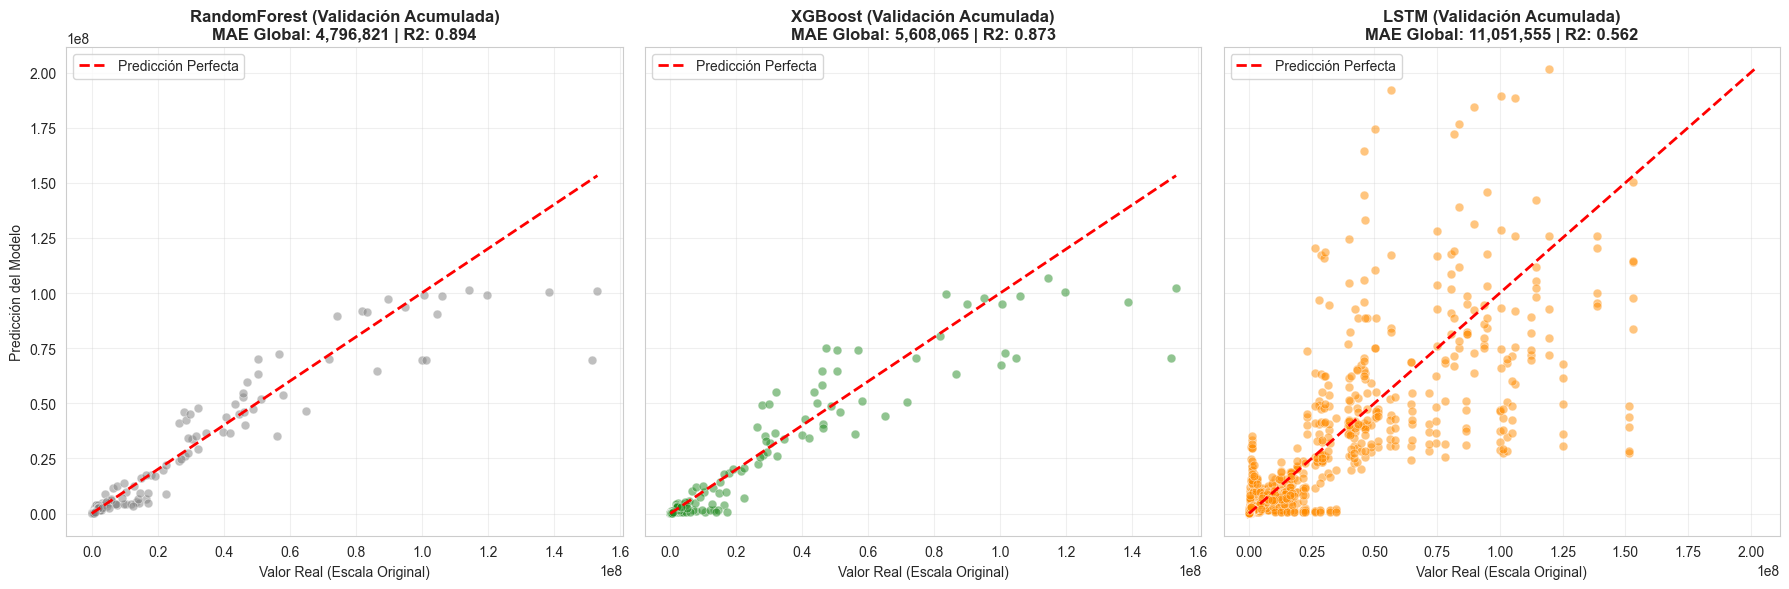

In [10]:
# =============================================================================
# 8. ANÁLISIS DE RESULTADOS Y GRÁFICOS (SIN REENTRENAMIENTO)
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# 1. TABLA DE RESULTADOS
all_results = []
for model_name, entries in results_detailed.items():
    for res in entries:
        all_results.append({"model": model_name, **res})

if all_results:
    df_results = pd.DataFrame(all_results)
    
    print("\nResultados Detallados por Fold:")
    try:
        display(df_results.drop(columns=['hyperparameters']))
    except:
        print(df_results.drop(columns=['hyperparameters']))
    
    print("\n" + "="*50)
    
    # Resumen Estadístico
    metric_cols = [c for c in ["MAE", "RMSE", "R2", "MAPE"] if c in df_results.columns]
    summary = df_results.groupby("model")[metric_cols].agg(['mean', 'std'])
    
    print("RESUMEN DE RENDIMIENTO (Media +/- Desviación Estándar):")
    try:
        display(summary)
    except:
        print(summary)
    print("="*50)
    
    

    # -----------------------------------------------------------------------------
    # 2. GRÁFICO COMPARATIVO (USANDO DATOS ACUMULADOS DE FOLDS)
    # -----------------------------------------------------------------------------
    print("\n" + "="*50)
    print("📊 GENERANDO GRÁFICO ACUMULADO DE VALIDACIÓN")
    
    # Filtramos solo modelos que tienen datos guardados
    models_to_plot = [m for m in predictions_log.keys() if len(predictions_log[m]['y_true']) > 0]
    n_models = len(models_to_plot)
    
    if n_models > 0:
        fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 6), sharey=True)
        if n_models == 1: axes = [axes]
        else: axes = axes.flatten()
        
        colors_map = {'Random Forest': 'royalblue', 'XGBoost': 'forestgreen', 'LSTM': 'darkorange'}
        
        for i, model in enumerate(models_to_plot):
            ax = axes[i]
            
            # Recuperamos los datos acumulados de los 5 folds
            y_t_log = np.array(predictions_log[model]['y_true'])
            y_p_log = np.array(predictions_log[model]['y_pred'])
            
            # Deshacer Logaritmo (Para ver escala real en la tesis)
            real = np.expm1(y_t_log)
            pred = np.expm1(y_p_log)
            
            # Scatter Plot
            color = colors_map.get(model, 'gray')
            sns.scatterplot(x=real, y=pred, alpha=0.5, color=color, ax=ax, s=40)
            
            # Línea de perfección (Identidad)
            max_val = max(real.max(), pred.max())
            min_val = min(real.min(), pred.min())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
            
            # Métricas Globales (sobre todos los folds unidos)
            mae_global = np.mean(np.abs(real - pred))
            r2_global = r2_score(real, pred)
            
            ax.set_title(f"{model} (Validación Acumulada)\nMAE Global: {mae_global:,.0f} | R2: {r2_global:.3f}", 
                         fontsize=12, fontweight='bold')
            ax.set_xlabel("Valor Real (Escala Original)")
            if i == 0: ax.set_ylabel("Predicción del Modelo")
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper left')
        
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No hay datos de predicción guardados para graficar.")

else:
    print("❌ Error: No se generaron resultados.")

# =============================================================================



############################################################
 ANALISIS DE RESULTADOS: CON_LAGS_TARGET
############################################################

--- Resultados Detallados por Fold (con_lags_target) ---


,model,MAE,RMSE,R2,MAPE,SMAPE
0,RandomForest,6.369668e+06,8.522065e+06,0.640800,1.145302e+03,75.928106
1,RandomForest,8.012135e+06,1.767917e+07,0.785007,4.989971e+01,39.095633
2,RandomForest,2.653190e+06,5.494406e+06,0.957392,6.208953e+01,42.675633
3,RandomForest,1.264822e+06,1.724844e+06,0.982416,5.513757e+01,38.563525
4,RandomForest,5.684290e+06,1.260287e+07,0.934516,3.126175e+01,35.587063
5,XGBoost,8.802916e+06,1.180574e+07,0.310662,1.120584e+03,114.687056
6,XGBoost,8.152771e+06,1.786362e+07,0.780498,4.113090e+01,36.680620
7,XGBoost,3.647547e+06,8.165122e+06,0.905903,6.363145e+01,44.621059
8,XGBoost,1.381069e+06,1.980196e+06,0.976824,8.391138e+01,46.450083
9,XGBoost,6.056024e+06,1.295286e+07,0.930829,3.288447e+01,44.280710



--- Resumen de Rendimiento: Media +/- Desviación (con_lags_target) ---


MAE                        RMSE                \
                      mean           std          mean           std   
model                                                                  
LSTM          1.346864e+07  8.358640e+06  2.748014e+07  1.728561e+07   
RandomForest  4.796821e+06  2.769019e+06  9.204669e+06  6.195656e+06   
XGBoost       5.608065e+06  3.106219e+06  1.055351e+07  5.915420e+06   

                    R2                    MAPE                    SMAPE  \
                  mean       std          mean           std       mean   
model                                                                     
LSTM          0.139435  1.128162  4.969050e+13  7.100869e+13  66.452357   
RandomForest  0.860026  0.144651  2.687381e+02  4.901476e+02  46.369992   
XGBoost       0.780943  0.272770  2.684284e+02  4.767868e+02  57.343906   

                         
                    std  
model                    
LSTM          22.193490  
RandomForest  16.714209  
XGBoost       32.273835


--- Visualización de Validación Acumulada (con_lags_target) ---


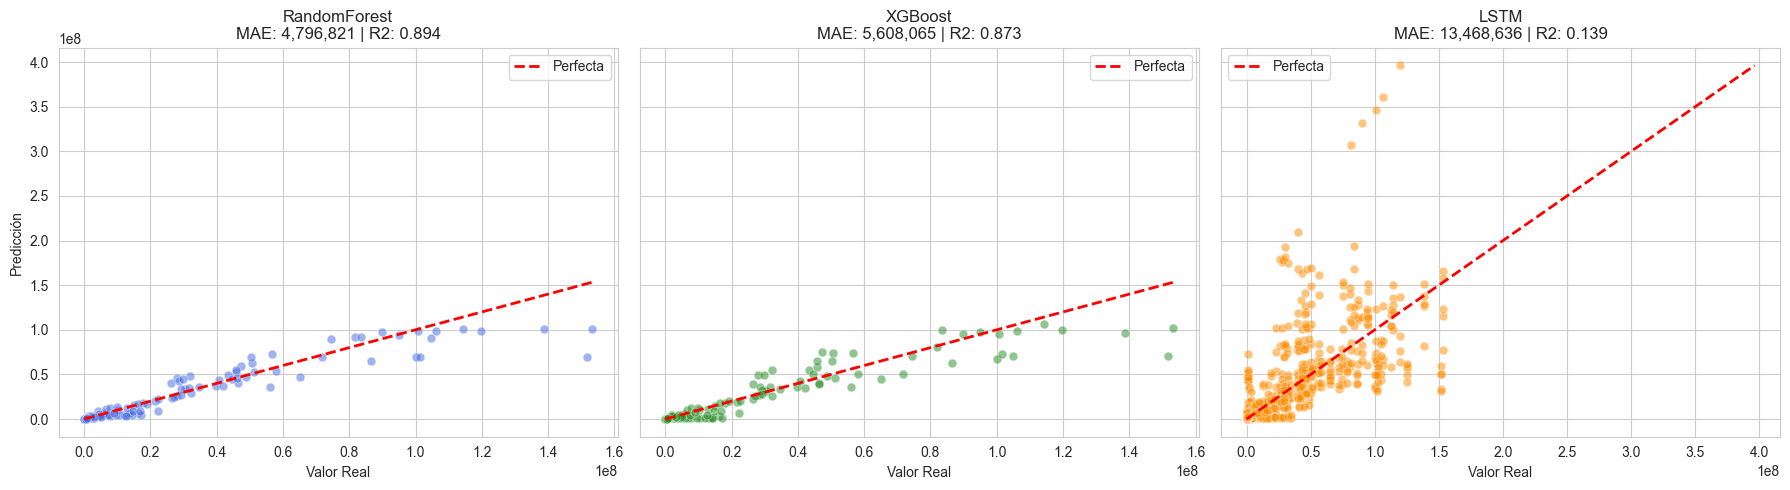



############################################################
 ANALISIS DE RESULTADOS: SIN_LAGS_TARGET
############################################################

--- Resultados Detallados por Fold (sin_lags_target) ---


,model,MAE,RMSE,R2,MAPE,SMAPE
0,RandomForest,1.026688e+07,1.444654e+07,-0.032225,1.114036e+03,99.658458
1,RandomForest,1.459914e+07,2.479987e+07,0.576943,5.833977e+02,88.648308
2,RandomForest,8.869638e+06,1.637263e+07,0.621657,9.666237e+01,70.531355
3,RandomForest,8.718407e+06,1.060241e+07,0.335594,4.902833e+02,103.718490
4,RandomForest,2.507758e+07,3.745481e+07,0.421624,4.575832e+02,96.991925
5,XGBoost,1.096288e+07,1.614460e+07,-0.289143,1.196420e+03,116.842324
6,XGBoost,1.956235e+07,3.332043e+07,0.236302,3.937457e+02,106.593081
7,XGBoost,6.893862e+06,1.416388e+07,0.716852,8.613633e+01,62.112875
8,XGBoost,1.414914e+07,1.943503e+07,-1.232517,6.744455e+02,115.126528
9,XGBoost,1.992935e+07,3.077320e+07,0.609572,4.013391e+02,85.000295



--- Resumen de Rendimiento: Media +/- Desviación (sin_lags_target) ---


MAE                        RMSE                \
                      mean           std          mean           std   
model                                                                  
LSTM          7.673375e+06  8.603449e+05  1.725130e+07  2.236032e+06   
RandomForest  1.350633e+07  6.892120e+06  2.073525e+07  1.069251e+07   
XGBoost       1.429952e+07  5.598929e+06  2.276743e+07  8.724191e+06   

                    R2                    MAPE                    SMAPE  \
                  mean       std          mean           std       mean   
model                                                                     
LSTM          0.738931  0.068227  4.502854e+10  9.965025e+10  47.346298   
RandomForest  0.384719  0.260148  5.483924e+02  3.663538e+02  91.909707   
XGBoost       0.008213  0.797442  5.504173e+02  4.168422e+02  97.135021   

                         
                    std  
model                    
LSTM           3.341551  
RandomForest  13.162353  
XGBoost       23.320213


--- Visualización de Validación Acumulada (sin_lags_target) ---


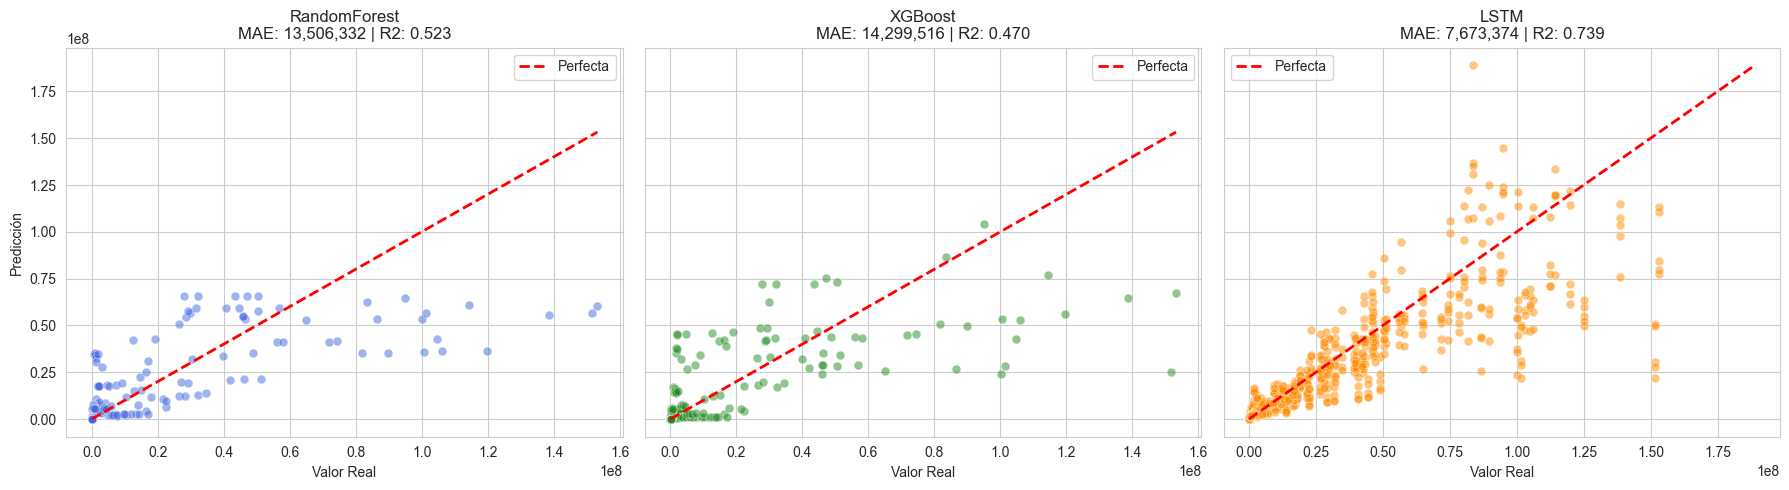

In [11]:
# =============================================================================
# 8. ANÁLISIS COMPARATIVO FINAL: CON LAGS VS SIN LAGS (BLOQUE AJUSTADO)
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

scenarios = ['con_lags_target', 'sin_lags_target']
colors_map = {'RandomForest': 'royalblue', 'XGBoost': 'forestgreen', 'LSTM': 'darkorange'}

for scenario in scenarios:
    print(f"\n\n" + "#" * 60)
    print(f" ANALISIS DE RESULTADOS: {scenario.upper()}")
    print("#" * 60)
    
    # 1. TABLA DE RESULTADOS DETALLADOS POR FOLD
    all_results = []
    for model_name, entries in results_master[scenario].items():
        for res in entries:
            all_results.append({"model": model_name, **res})

    if all_results:
        df_results = pd.DataFrame(all_results)
        
        print(f"\n--- Resultados Detallados por Fold ({scenario}) ---")
        # Mostramos la tabla de folds
        display(df_results)
        
        # 2. RESUMEN ESTADÍSTICO (MÉTRICAS)
        metric_cols = ["MAE", "RMSE", "R2", "MAPE", "SMAPE"]
        summary = df_results.groupby("model")[metric_cols].agg(['mean', 'std'])
        
        print(f"\n--- Resumen de Rendimiento: Media +/- Desviación ({scenario}) ---")
        display(summary)
        
        # 3. GRÁFICOS COMPARATIVOS (REAL VS PREDICHO)
        print(f"\n--- Visualización de Validación Acumulada ({scenario}) ---")
        
        # Filtramos modelos que tengan datos de predicción
        models_to_plot = [m for m in ["RandomForest", "XGBoost", "LSTM"] 
                          if len(predictions_master[scenario][m]['y_true']) > 0]
        n_models = len(models_to_plot)
        
        if n_models > 0:
            fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5), sharey=True)
            if n_models == 1: axes = [axes]
            
            for i, model in enumerate(models_to_plot):
                ax = axes[i]
                
                # Recuperamos datos acumulados
                y_true_log = np.array(predictions_master[scenario][model]['y_true'])
                y_pred_log = np.array(predictions_master[scenario][model]['y_pred'])
                
                # Revertimos logaritmo para escala real
                real = np.expm1(y_true_log)
                pred = np.expm1(y_pred_log)
                
                # Scatter Plot
                sns.scatterplot(x=real, y=pred, alpha=0.5, color=colors_map[model], ax=ax, s=40)
                
                # Línea de identidad
                max_val = max(real.max(), pred.max())
                min_val = min(real.min(), pred.min())
                ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfecta')
                
                # Métricas globales del escenario
                mae_global = np.mean(np.abs(real - pred))
                r2_global = r2_score(real, pred)
                
                ax.set_title(f"{model}\nMAE: {mae_global:,.0f} | R2: {r2_global:.3f}")
                ax.set_xlabel("Valor Real")
                if i == 0: ax.set_ylabel("Predicción")
                ax.legend()
            
            plt.tight_layout()
            plt.show()
    else:
        print(f"No se encontraron resultados para el escenario: {scenario}")


📊 COMPARATIVA DE ESCENARIOS (PROMEDIOS):


,scenario,model,MAE,R2
0,con_lags_target,LSTM,1.346864e+07,0.139435
1,con_lags_target,RandomForest,4.796821e+06,0.860026
2,con_lags_target,XGBoost,5.608065e+06,0.780943
3,sin_lags_target,LSTM,7.673375e+06,0.738931
4,sin_lags_target,RandomForest,1.350633e+07,0.384719
5,sin_lags_target,XGBoost,1.429952e+07,0.008213


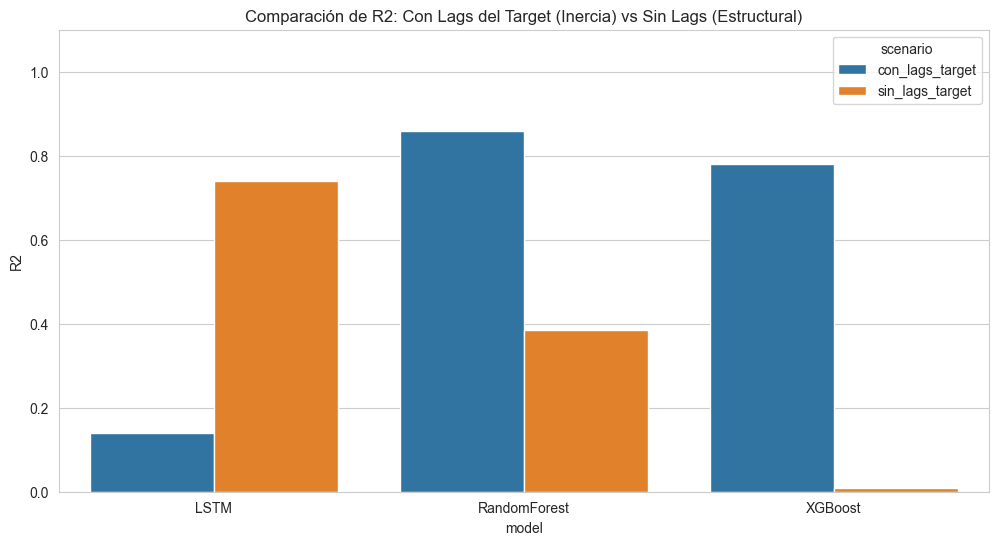

In [12]:
# =============================================================================
# 8.1  ANÁLISIS COMPARATIVO FINAL ENTRE ESCENARIOS
# =============================================================================
all_dfs = []
for scenario in scenarios:
    for model_name, metrics_list in results_master[scenario].items():
        temp_df = pd.DataFrame(metrics_list)
        temp_df['model'] = model_name
        temp_df['scenario'] = scenario
        all_dfs.append(temp_df)

df_final_comparison = pd.concat(all_dfs)

# Resumen por Escenario y Modelo
summary = df_final_comparison.groupby(['scenario', 'model'])[['MAE', 'R2']].mean().reset_index()

print("\n📊 COMPARATIVA DE ESCENARIOS (PROMEDIOS):")
display(summary)

# Gráfico comparativo de R2
plt.figure(figsize=(12, 6))
sns.barplot(data=summary, x='model', y='R2', hue='scenario')
plt.title("Comparación de R2: Con Lags del Target (Inercia) vs Sin Lags (Estructural)")
plt.ylim(0, 1.1)
plt.show()

In [ ]:
# =============================================================================
# BLOQUE 9 y 10 (CORREGIDO): ENTRENAMIENTO Y OBJETOS DE PREPROCESAMIENTO
# =============================================================================
from sklearn.linear_model import LinearRegression

# 1. Creamos y ENTRENAMOS los objetos (sin sobrescribirlos con el resultado)
imputer_final = IterativeImputer(random_state=SEED)
X_tab_imp = imputer_final.fit_transform(X_tab_full)

scaler_final = StandardScaler() # Este objeto es el que usaremos después
X_tab_sc = scaler_final.fit_transform(X_tab_imp) 

# 2. SEPARACIÓN DE COMPONENTES PARA EL MODELO HÍBRIDO
X_hybrid_df = pd.DataFrame(X_tab_sc, columns=X_tab_full.columns)
X_stage1_ine = X_hybrid_df[cols_inercia]
y_final = y_tab

# 3. ETAPA 1: Modelo de Inercia
model_trend_linear = LinearRegression()
model_trend_linear.fit(X_stage1_ine, y_final)

# 4. ETAPA 2: Modelo de Residuos (LSTM)
y_trend_full = model_trend_linear.predict(X_stage1_ine)
residuos_full = y_final - y_trend_full

print("✅ Objetos 'imputer_final' y 'scaler_final' reparados y listos para usar .transform()")

✅ Objetos 'imputer_final' y 'scaler_final' reparados y listos para usar .transform()


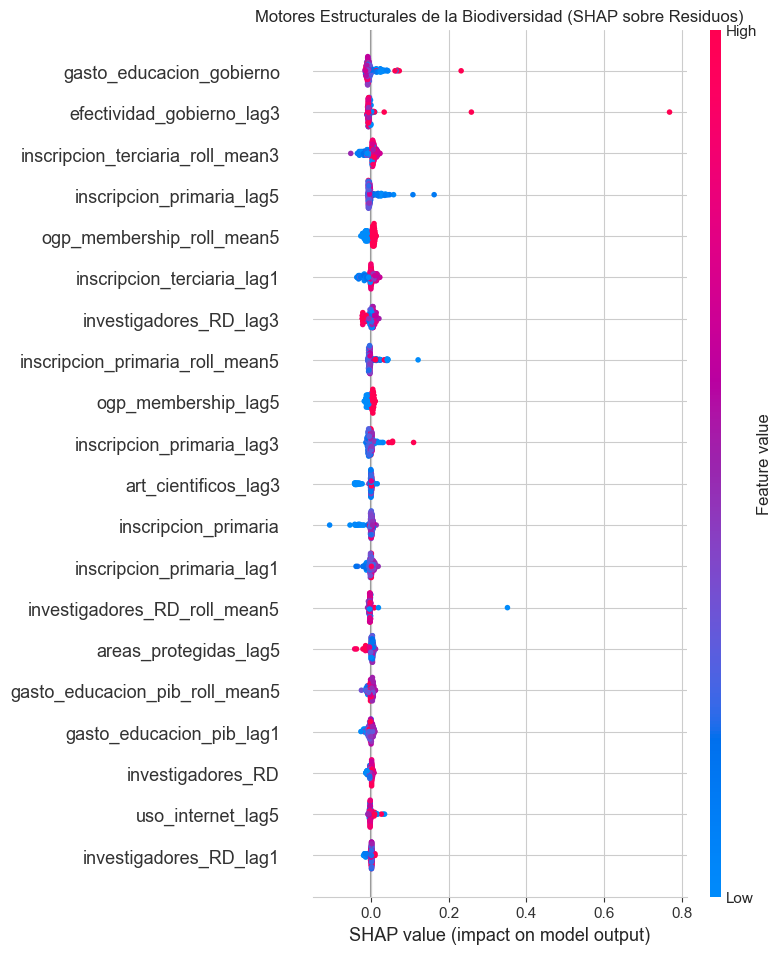

In [ ]:
# =============================================================================
# BLOQUE 11: ANÁLISIS DE IMPORTANCIA SOBRE RESIDUOS (SHAP)
# =============================================================================
# Para una interpretación clara en la tesis, usamos el RF optimizado 
# para explicar los residuos generados en el Bloque 10.
cols_estructural = [c for c in X_full_df.columns if c not in cols_inercia]
X_res_rf = X_full_df[cols_estructural]

explainer_res = shap.TreeExplainer(RandomForestRegressor(n_estimators=300).fit(X_res_rf, residuos_finales))
shap_values_res = explainer_res.shap_values(X_res_rf)

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_res, X_res_rf, feature_names=cols_estructural, show=False)
plt.title("Motores Estructurales de la Biodiversidad (SHAP sobre Residuos)")
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener importancia de variables
importances = final_model.feature_importances_
feat_imp = pd.Series(importances, index=features_tabular).sort_values(ascending=False)

# Graficar las 15 más importantes
feat_imp.head(30).plot(kind='barh')
plt.title("Variables que más influyen en la predicción")
plt.show()